# Usage

## API key

Before you can download any images (or any metadata about them) from Google StreetView, you have to register for Google’s Static StreetView API. Go to https://developers.google.com/maps/documentation/streetview/get-api-key and follow the instructions there. Be sure to also generate an URL signing secret.

## Command line utility

The quickest way of downloading StreetView images and their metadata is to use the command line utility `streetviewdownloader`:

```bash
$ streetviewdownloader --api-key ABCDEF --url-signing-key GHIJKL --extent "POLYGON((24.40 60.12, 24.45 60.11, 24.46 60.13, 24.40 60.12))"
```

## Python

For more advanced applications, such as saving the metadata only, or for integrating the StreetView data download into a workflow pipeline, you can also use Streetviewdownloader’s [Python API](reference.html).

In [1]:
# this cell is hidden from output
# it’s used to 
# - import credentials
# - hide the warnings that are displayed because 
#   of a current mismatch in geos versions between 
#   shapely and pygeos
# - set sys.path to point to the local streetviewdownloader repo
# - make ipython show all outputs of each cell
# - provide a helper function to unobstrusively plot geometries


# - import credentials
try:
    import yaml
    import os.path
    with open(os.path.expanduser("~/.config/streetviewdownloader.yaml")) as _config_file:
        _config = yaml.safe_load(_config_file)

    API_KEY = _config["API_KEY"]
    URL_SIGNING_KEY = _config["URL_SIGNING_KEY"]
    del _config
except (ImportError, FileNotFoundError, KeyError):
    try:
        import os
        API_KEY = os.environ["sv_API_KEY"]
        URL_SIGNING_KEY = os.environ["sv_URL_SIGNING_KEY"]
    except KeyError:
        API_KEY = ""
        URL_SIGNING_KEY = ""


# - hide the warnings that are displayed because 
#   of a current mismatch in geos versions between 
#   shapely and pygeos
import warnings
warnings.simplefilter("ignore")


# - set sys.path to point to the local streetviewdownloader repo
import sys
sys.path.append("../src/")


# - make ipython show all outputs of each cell
get_ipython().ast_node_interactivity = "all"


# - provide a helper function to unobstrusively plot geometries
import contextily
import geopandas
import matplotlib.pyplot
import shapely.geometry

def plot(*what_to_plot):
    fig, ax = matplotlib.pyplot.subplots(figsize = (10,10))
    for what in what_to_plot:
        if isinstance(what, shapely.geometry.base.BaseGeometry):
            what = geopandas.GeoDataFrame({"geometry": [what]}, crs="EPSG:4326")
        what.to_crs("EPSG:3875").plot(
            ax=ax,
            edgecolor="#2a65b8ff",
            facecolor="#3388ff33",
            linewidth=3,
            markersize=8
        )
    ax.set_axis_off()
    contextily.add_basemap(
        ax, 
        crs="EPSG:3875", 
        source=contextily.providers.OpenStreetMap.Mapnik,
        zoom=16
    )
    return ax

### Define download extent and download directory

For all examples below, we’ll download data for an area in the municipality of Kirkkonummi, about 50 km west of Helsinki, Finland. We’ll save the downloaded images and/or an associated `metadata.gpkg` into a subfolder of `~/Downloads/`:

<Axes: >

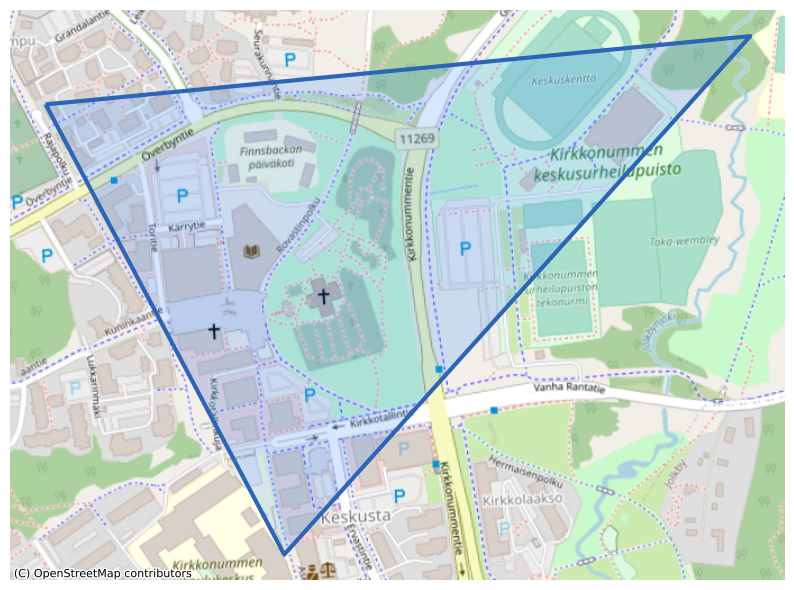

In [2]:
import shapely.wkt
import ipyleaflet


output_directory = "/home/USER/Downloads/StreetView/"
kirkkonummi = shapely.wkt.loads("POLYGON((24.4343 60.1269, 24.4478 60.1272, 24.4384 60.1225, 24.4343 60.1269))")

plot(kirkkonummi)

### Using `StreetViewDownloader()`

The simplest way of accessing the Python API is to use the `StreetViewDownloader()` class.

In [3]:
from streetviewdownloader import StreetViewDownloader

downloader = StreetViewDownloader(API_KEY, URL_SIGNING_KEY)
downloader.download(kirkkonummi, output_directory)

This downloads the metadata to `metadata.gpkg`, and all images into the output directory. Note that, by default, data is appended to an existing metadata dataset, and images existing in the directory are not downloaded again. If you want the metadata only, call `download()` with `metadata_only=True`.

Depending on the location and size of the extent, this operation can take a while. In the background, Streetviewdownloader carries out multiple steps:

1. Decide which OSM extract from either geofabrik.de or bbbike.org fits best for the extent (the smallest extract in which the extent is fully contained)
2. Download this OSM extract, and extract and clip the street network to the extent
3. Generate a point data set on this street network with at most 25 meter distance between points
4. Query the StreetView Static API for panoramas in the immediate vicinity of each point (and remove duplicates afterwards)
5. Download six images each for every panorama.

The results of the first two steps are cached for up to seven days, as they are the most expensive ones in respect to download time and processing time. They should complete fast in subsequent runs.

### Step by step

Some of these steps can be carried out individually, in order to fine-tune the results, or to save intermediary data sets.

#### 1-3. Generate equidistant points on the street network

,geometry
0,POINT (24.43637 60.12480)
1,POINT (24.43647 60.12464)
2,POINT (24.43623 60.12563)
3,POINT (24.43656 60.12565)
4,POINT (24.43689 60.12566)


<Axes: >

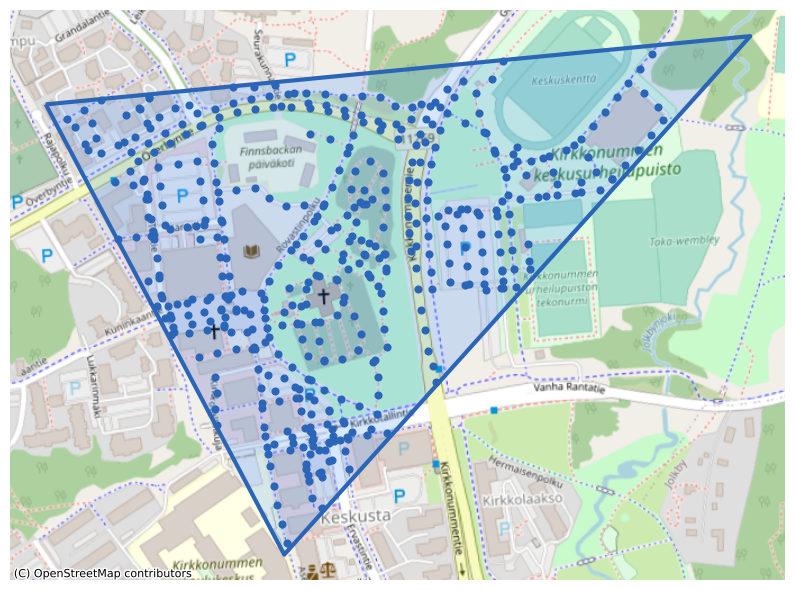

In [4]:
from streetviewdownloader import StreetNetworkPointGenerator

point_generator = StreetNetworkPointGenerator()
points = point_generator.points_on_street_network(kirkkonummi)

points.head()
plot(kirkkonummi, points)

#### 4. Query the StreetView API for panoramas close to each point

,date,geometry,pano_id
0,2021-08-01,POINT (24.44005 60.12662),cLfEWSeeQq54YgoQm0Audg
1,2021-08-01,POINT (24.43969 60.12668),MRs1pW7z6GzmkiRpkGg-Sw
2,2021-08-01,POINT (24.43934 60.12672),aWrLemUbLXzVaGcprc1oUg
3,2021-08-01,POINT (24.43898 60.12675),vcOJ68wXPr3Qt1G_3NzZRA
4,2021-08-01,POINT (24.43872 60.12675),ABf-m6zh5T814eMNyn5LeQ


<Axes: >

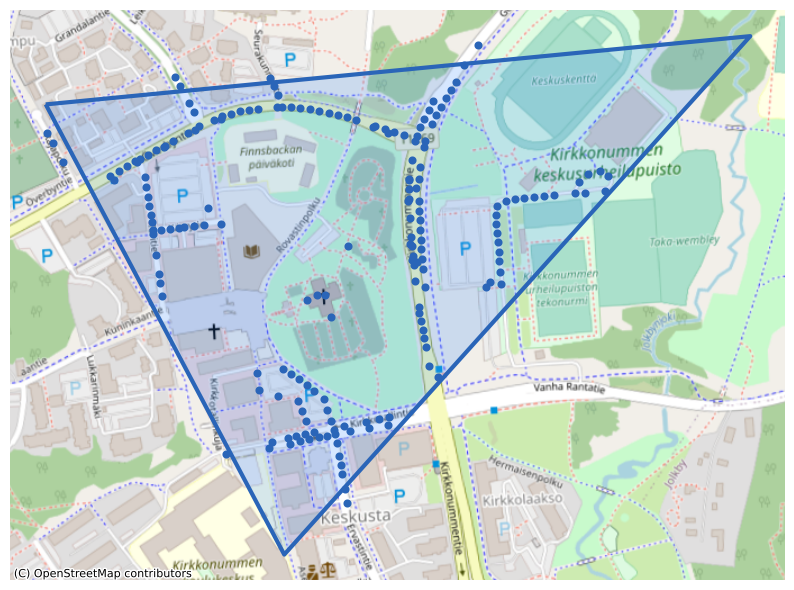

In [5]:
from streetviewdownloader import StreetViewMetadataDownloader

metadata_downloader = StreetViewMetadataDownloader(API_KEY, URL_SIGNING_KEY)
metadata = metadata_downloader.download(points)

metadata.head()
plot(kirkkonummi, metadata)

The metadata describes all panoramas that are available inside in the extent.\

This is a good moment to estimate the costs of downloading all images (querying metadata is free). At the time of this writing, the [price for downloading one image is 0.007 USD](https://developers.google.com/maps/documentation/streetview/usage-and-billing#static-street-view). The way Streetviewdownloader obtains the images, each panorama consists of six individual images covering a field-of-view of 60°, each.

In [6]:
estimated_costs = len(metadata) * 6 * 0.007
estimated_costs

7.938

#### 5. Download the individual images

In [7]:
from streetviewdownloader import StreetViewImageDownloader
image_downloader = StreetViewImageDownloader(API_KEY, URL_SIGNING_KEY)
image_downloader.download(metadata, output_directory)